In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [2]:
!pip install -q "monai[all]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 22.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 26.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 68.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 67.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 93.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-05-17 12:58:16.752144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747486696.936389      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747486696.992556      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


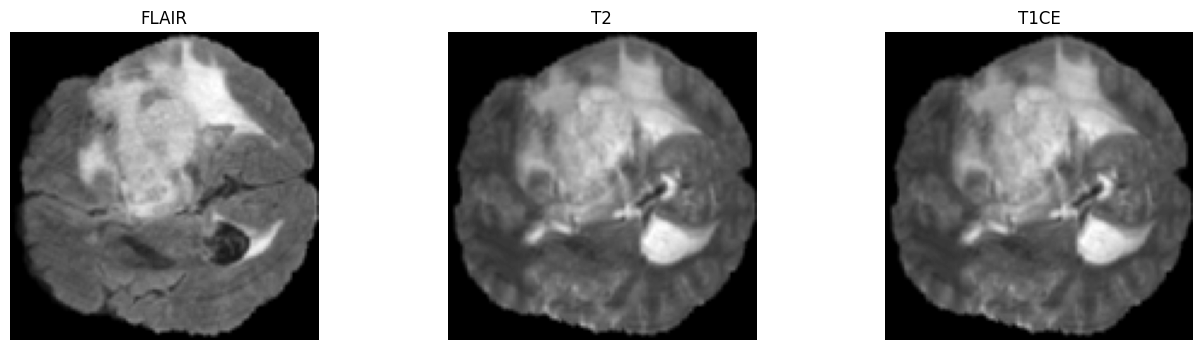

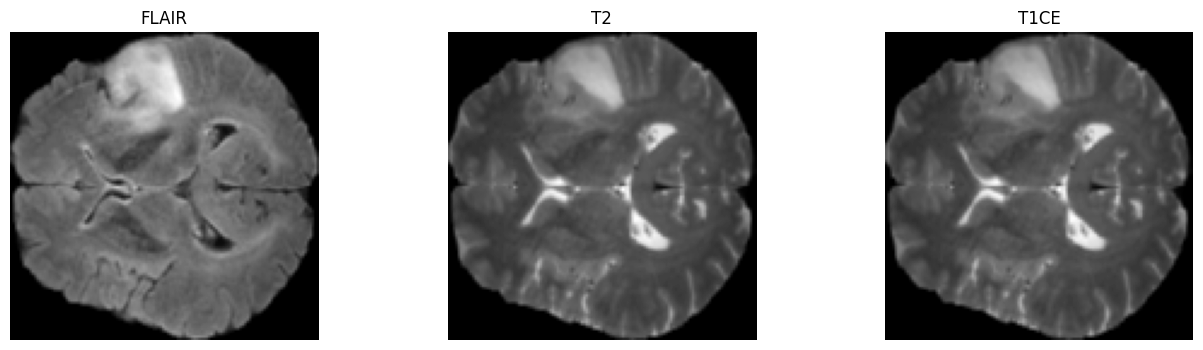

Processed 369 patients successfully


In [3]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityRanged,
    CropForegroundd, Resized, ToTensord, SpatialCropd
)
from monai.data import Dataset, DataLoader

# مسارات الداتاسيت
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
output_dir = "/kaggle/working/processed"
os.makedirs(output_dir, exist_ok=True)

# قايمة الحالات
patient_list = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and not d.endswith(".csv")])

# إنشاء فولدرات لكل مريض
for patient in patient_list:
    os.makedirs(os.path.join(output_dir, patient), exist_ok=True)

# إعداد قايمة البيانات (FLAIR, T2, T1CE)
data_dicts = []
skipped_patients = []
for patient in patient_list:
    flair_path = os.path.join(data_dir, patient, f"{patient}_flair.nii")
    t2_path = os.path.join(data_dir, patient, f"{patient}_t2.nii")
    t1ce_path = os.path.join(data_dir, patient, f"{patient}_t1ce.nii")
    try:
        # فحص وجود الملفات
        if not (os.path.exists(flair_path) and os.path.exists(t2_path) and os.path.exists(t1ce_path)):
            skipped_patients.append((patient, "Missing file(s)"))
            continue
        # فحص تحميل الملفات
        nib.load(flair_path)
        nib.load(t2_path)
        nib.load(t1ce_path)
        data_dicts.append({
            "flair": flair_path,
            "t2": t2_path,
            "t1ce": t1ce_path,
        })
    except Exception as e:
        skipped_patients.append((patient, f"Failed to load files: {str(e)}"))
        continue

# تعريف التحويلات
transforms = Compose([
    LoadImaged(keys=["flair", "t2", "t1ce"]),
    EnsureChannelFirstd(keys=["flair", "t2", "t1ce"]),
    Spacingd(keys=["flair", "t2", "t1ce"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    ScaleIntensityRanged(keys=["flair", "t2", "t1ce"], a_min=0, a_max=4000, b_min=0, b_max=1, clip=True),
    CropForegroundd(keys=["flair", "t2", "t1ce"], source_key="flair", allow_smaller=False),
    Resized(keys=["flair", "t2", "t1ce"], spatial_size=(128, 128, 155)),
    SpatialCropd(keys=["flair", "t2", "t1ce"], roi_start=[0, 0, 30], roi_end=[128, 128, 110]),  # 128x128x80
    ToTensord(keys=["flair", "t2", "t1ce"])
])

# إعداد الداتاسيت والـ DataLoader
dataset = Dataset(data=data_dicts, transform=transforms)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

# معالجة وحفظ الصور
processed_count = 0
display_patients = patient_list[:2]  # أول اتنين بيشنت للعرض
display_images = []

for i, data in enumerate(dataloader):
    if i >= len(data_dicts):
        break
    patient_id = data_dicts[i]["flair"].split("/")[-2]  # استخراج patient_id من المسار
    
    patient_output_dir = os.path.join(output_dir, patient_id)
    
    flair, t2, t1ce = data["flair"][0], data["t2"][0], data["t1ce"][0]
    
    # تحويل إلى NumPy لحفظها
    flair_np = flair.numpy().squeeze()
    t2_np = t2.numpy().squeeze()
    t1ce_np = t2.numpy().squeeze()
    
    # حفظ الصور كـ NIFTI
    for modality, img in [("flair", flair_np), ("t2", t2_np), ("t1ce", t1ce_np)]:
        output_path = os.path.join(patient_output_dir, f"{modality}.nii.gz")
        nii_img = nib.Nifti1Image(img, affine=np.eye(4))
        nib.save(nii_img, output_path)
    
    # تخزين الصور للعرض
    if patient_id in display_patients:
        display_images.append({
            "patient_id": patient_id,
            "flair": flair_np[:, :, 48],
            "t2": t2_np[:, :, 48],
            "t1ce": t1ce_np[:, :, 48]
        })
    
    processed_count += 1

# عرض الصور
for patient_data in display_images:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    axes[0].imshow(patient_data["flair"], cmap="gray")
    axes[0].set_title("FLAIR")
    axes[0].axis("off")
    axes[1].imshow(patient_data["t2"], cmap="gray")
    axes[1].set_title("T2")
    axes[1].axis("off")
    axes[2].imshow(patient_data["t1ce"], cmap="gray")
    axes[2].set_title("T1CE")
    axes[2].axis("off")
    plt.show()

# طباعة النتائج
print(f"Processed {processed_count} patients successfully")
if skipped_patients:
    print("Skipped patients:")
    for patient, reason in skipped_patients:
        print(f"Patient {patient}: {reason}")
if processed_count < len(patient_list):
    print(f"Warning: Expected to process {len(patient_list)} patients, but only processed {processed_count}")

Comparison with T1ce (average over 150 patients)
  - MSE  : 0.005687
  - PSNR : 23.5375 dB
  - SSIM : 0.9001
  - Entropy : 14.0000
  - MI : 2.2138
--------------------------
Comparison with T2 (average over 150 patients)
  - MSE  : 0.005687
  - PSNR : 23.5375 dB
  - SSIM : 0.9001
  - Entropy : 14.0000
  - MI : 2.2138
--------------------------
Comparison with FLAIR (average over 150 patients)
  - MSE  : 0.009685
  - PSNR : 20.6142 dB
  - SSIM : 0.7163
  - Entropy : 14.0000
  - MI : 1.7463
--------------------------


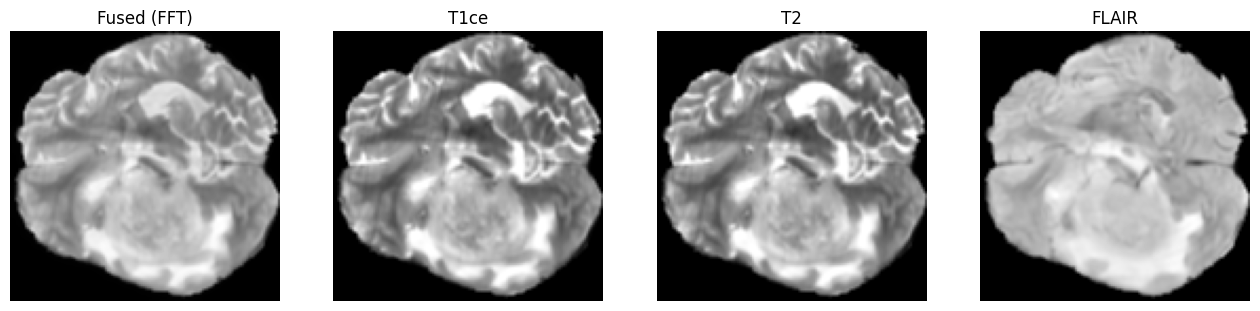

In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from skimage.metrics import structural_similarity as calculate_ssim
from skimage.metrics import mean_squared_error as calculate_mse
from skimage.measure import shannon_entropy

def load_and_normalize(path, slice_range=None):
    """تحميل وتطبيع الصورة ثلاثية الأبعاد"""
    img = nib.load(path).get_fdata()
    if slice_range:
        img = img[:, :, slice_range[0]:slice_range[1]]
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

def mutual_information(image1, image2, bins=100):
    joint_hist, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins, range=[[0, 1], [0, 1]])
    joint_hist = joint_hist / np.sum(joint_hist)
    hist1 = np.sum(joint_hist, axis=1)
    hist2 = np.sum(joint_hist, axis=0)
    entropy1 = -np.sum(hist1[hist1 > 0] * np.log2(hist1[hist1 > 0]))
    entropy2 = -np.sum(hist2[hist2 > 0] * np.log2(hist2[hist2 > 0]))
    joint_entropy = -np.sum(joint_hist[joint_hist > 0] * np.log2(joint_hist[joint_hist > 0]))
    mi = entropy1 + entropy2 - joint_entropy
    return mi

base_path = "/kaggle/working/processed"
output_dir = "/kaggle/working/fused"
os.makedirs(output_dir, exist_ok=True)

patient_list = [f'BraTS20_Training_{str(i).zfill(3)}' for i in range(1, 151)]
slice_range = (0, 80)  # Already cropped to 80 slices (30:110) in preprocessing

metrics = {'T1ce': [], 'T2': [], 'FLAIR': []}
last_images = {'T1ce': None, 'T2': None, 'FLAIR': None, 'Fused': None}

for patient in patient_list:
    data_paths = {
        "T1ce": os.path.join(base_path, patient, "t1ce.nii.gz"),
        "T2": os.path.join(base_path, patient, "t2.nii.gz"),
        "FLAIR": os.path.join(base_path, patient, "flair.nii.gz")
    }

    modalities = {}
    for mod, path in data_paths.items():
        try:
            if os.path.exists(path):
                modalities[mod] = load_and_normalize(path, slice_range=None)  # Slice range already handled in preprocessing
            else:
                print(f"تحذير: الملف غير موجود - {path}")
        except Exception as e:
            print(f"خطأ في تحميل {mod} للمريض {patient}: {str(e)}")

    if len(modalities) != 3:  # Ensure all modalities are present
        print(f"تخطي المريض {patient}: لم يتم تحميل جميع البيانات")
        continue

    def create_adaptive_filters(volumes, sigma_low=18, sigma_high=4):
        low_pass = gaussian_filter(np.ones_like(volumes["FLAIR"]), sigma=sigma_low)
        t1ce_grad = np.abs(np.gradient(volumes["T1ce"])[0])
        t2_grad = np.abs(np.gradient(volumes["T2"])[0])
        edge_strength = np.clip(t1ce_grad + t2_grad, 0, 1)
        high_pass = 1 - gaussian_filter(edge_strength, sigma=sigma_high)
        return low_pass / low_pass.max(), high_pass / high_pass.max()

    low_pass, high_pass = create_adaptive_filters(modalities)

    fft_shifted = {mod: np.fft.fftshift(np.fft.fftn(modalities[mod])) for mod in modalities}

    weights = {"FLAIR": 0.5, "T1ce": 0.4, "T2": 0.3}

    fused_fft = np.zeros_like(fft_shifted["FLAIR"])
    for mod in modalities:
        if mod == "FLAIR":
            fused_fft += fft_shifted[mod] * low_pass * weights[mod]
        else:
            fused_fft += fft_shifted[mod] * high_pass * weights[mod]

    fused_volume = np.abs(np.fft.ifftn(np.fft.ifftshift(fused_fft)))
    fused_volume = (fused_volume - fused_volume.min()) / (fused_volume.max() - fused_volume.min() + 1e-8)

    for name, img in modalities.items():
        mse_value = calculate_mse(fused_volume, img)
        psnr_value = calculate_psnr(fused_volume, img, data_range=1.0)
        ssim_value = np.mean([calculate_ssim(fused_volume[:, :, i], img[:, :, i], data_range=1.0) for i in range(80)])
        entropy_value = np.mean([shannon_entropy(fused_volume[:, :, i]) for i in range(80)])
        mi_value = np.mean([mutual_information(fused_volume[:, :, i], img[:, :, i]) for i in range(80)])

        metrics[name].append({
            'Patient': patient,
            'MSE': mse_value,
            'PSNR': psnr_value,
            'SSIM': ssim_value,
            'Entropy': entropy_value,
            'MI': mi_value
        })

    patient_output_dir = os.path.join(output_dir, patient)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, f"{patient}_fused.nii.gz")
    nib.save(nib.Nifti1Image(fused_volume, np.eye(4)), output_path)

    last_images['T1ce'] = modalities['T1ce']
    last_images['T2'] = modalities['T2']
    last_images['FLAIR'] = modalities['FLAIR']
    last_images['Fused'] = fused_volume

for name in metrics:
    df = pd.DataFrame(metrics[name])
    df.to_csv(f'metrics_{name}.csv', index=False)

    mse_avg = np.mean([m['MSE'] for m in metrics[name]])
    psnr_avg = np.mean([m['PSNR'] for m in metrics[name]])
    ssim_avg = np.mean([m['SSIM'] for m in metrics[name]])
    entropy_avg = np.mean([m['Entropy'] for m in metrics[name]])
    mi_avg = np.mean([m['MI'] for m in metrics[name]])

    print(f"Comparison with {name} (average over 150 patients)")
    print(f"  - MSE  : {mse_avg:.6f}")
    print(f"  - PSNR : {psnr_avg:.4f} dB")
    print(f"  - SSIM : {ssim_avg:.4f}")
    print(f"  - Entropy : {entropy_avg:.4f}")
    print(f"  - MI : {mi_avg:.4f}")
    print("--------------------------")

if last_images['Fused'] is not None:
    slice_idx = 40
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1); plt.imshow(last_images['Fused'][:, :, slice_idx], cmap='gray'); plt.title("Fused (FFT)"); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(last_images['T1ce'][:, :, slice_idx], cmap='gray'); plt.title("T1ce"); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(last_images['T2'][:, :, slice_idx], cmap='gray'); plt.title("T2"); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(last_images['FLAIR'][:, :, slice_idx], cmap='gray'); plt.title("FLAIR"); plt.axis('off')
    plt.savefig('fused_images.png')
else:
    print("لا يوجد صور للعرض بسبب عدم تحميل البيانات.")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


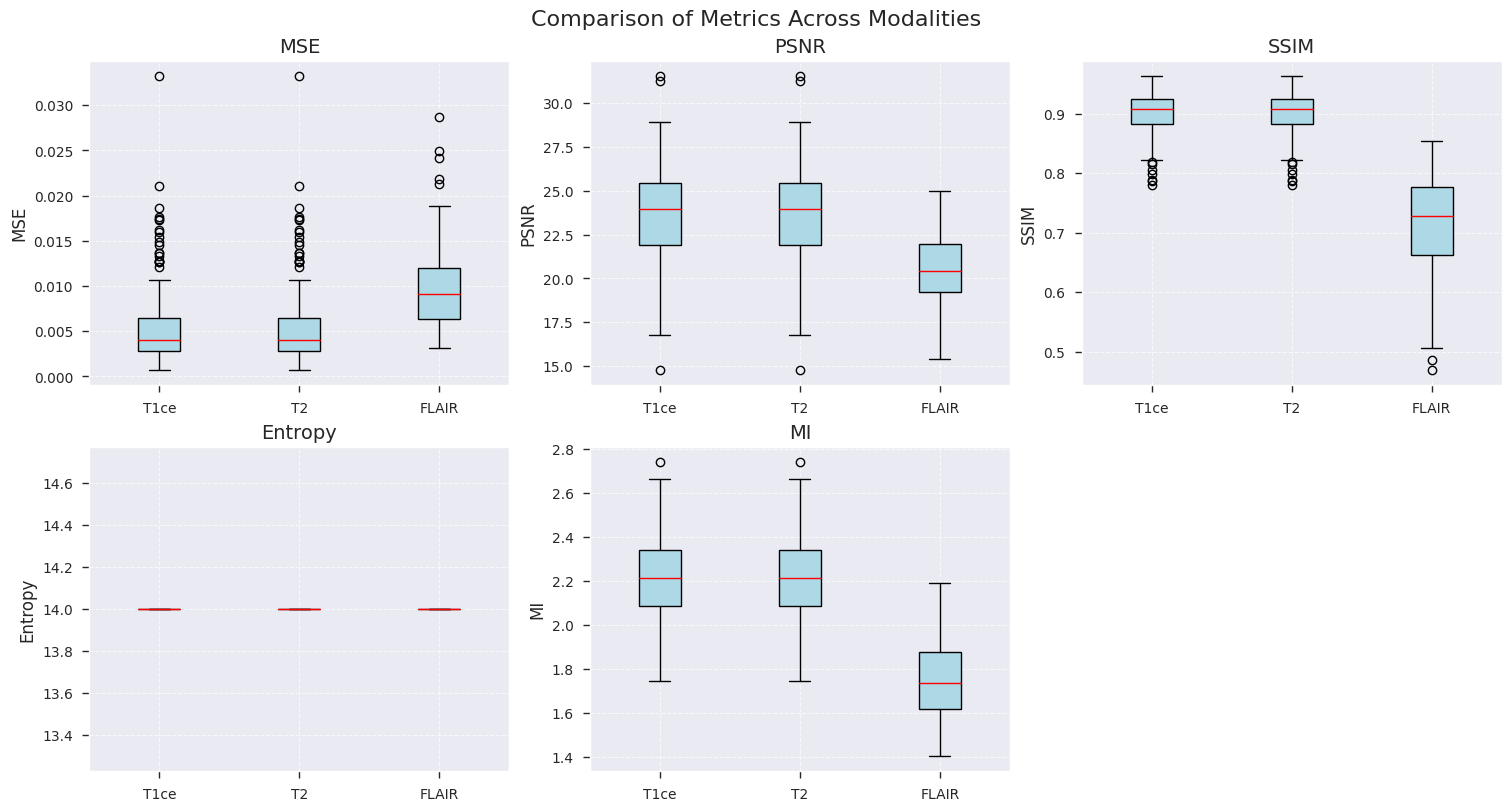

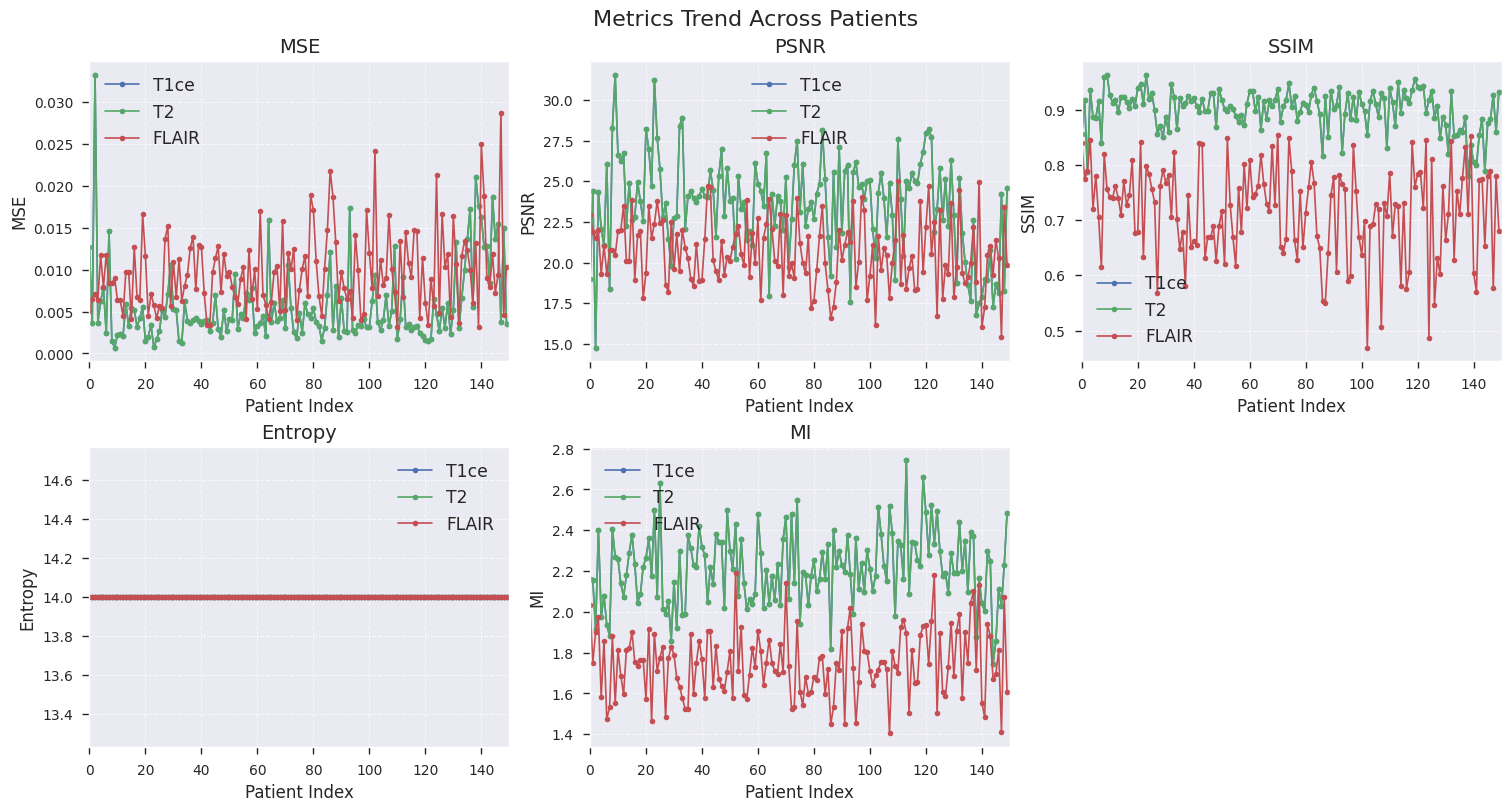

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.measure import shannon_entropy
from scipy.stats import entropy as scipy_entropy
import os

# Set plotting style for research paper
plt.style.use('seaborn')
sns.set_context("paper", font_scale=1.4)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Paths
output_path = '/kaggle/working'
metrics_files = {
    'T1ce': 'metrics_T1ce.csv',
    'T2': 'metrics_T2.csv',
    'FLAIR': 'metrics_FLAIR.csv'
}

# Function to calculate Mutual Information
def mutual_information(img1, img2, bins=256):
    # Flatten images
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    
    # Compute histograms
    hist_2d, x_edges, y_edges = np.histogram2d(img1_flat, img2_flat, bins=bins)
    hist_2d = hist_2d / np.sum(hist_2d)  # Normalize to get joint probability
    hist_1 = np.sum(hist_2d, axis=1)
    hist_2 = np.sum(hist_2d, axis=0)
    
    # Compute entropies
    mi = 0
    for i in range(bins):
        for j in range(bins):
            if hist_2d[i, j] > 0:
                mi += hist_2d[i, j] * np.log2(hist_2d[i, j] / (hist_1[i] * hist_2[j]))
    return mi

# Load metrics and add MI if not present
metrics_data = {}
for modality, file in metrics_files.items():
    file_path = os.path.join(output_path, file)
    if not os.path.exists(file_path):
        print(f"Metrics file not found: {file_path}")
        continue
    
    df = pd.read_csv(file_path)
    
    # If MI is not in the dataframe, calculate it (assuming images are available)
    if 'MI' not in df.columns:
        mi_values = []
        for idx, row in df.iterrows():
            patient = row['Patient']
            patient_path = os.path.join('/kaggle/working/processed', patient)
            fused_path = os.path.join(patient_path, 'fused_final_3d.nii.gz')
            modality_path = os.path.join(patient_path, f'{modality.lower()}.nii.gz')
            
            try:
                fused_img = nib.load(fused_path).get_fdata()[:, :, 30:min(110, int(row['Num_Slices']))]
                modality_img = nib.load(modality_path).get_fdata()[:, :, 30:min(110, int(row['Num_Slices']))]
                mi = mutual_information(fused_img, modality_img)
                mi_values.append(mi)
            except:
                mi_values.append(np.nan)  # In case of error, append NaN
        df['MI'] = mi_values
    
    metrics_data[modality] = df

# Metrics to plot
metrics_to_plot = ['MSE', 'PSNR', 'SSIM', 'Entropy', 'MI']

# Create Boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    data = []
    labels = []
    for modality in metrics_data:
        values = metrics_data[modality][metric].dropna()
        data.append(values)
        labels.append(modality)
    
    axes[idx].boxplot(data, labels=labels, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue', color='black'),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     medianprops=dict(color='red'))
    axes[idx].set_title(metric)
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplot if any
for idx in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Comparison of Metrics Across Modalities', fontsize=16)
plt.savefig(os.path.join(output_path, 'boxplots_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create Line Plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    for modality in metrics_data:
        df = metrics_data[modality].sort_values('Patient')
        values = df[metric].dropna()
        axes[idx].plot(df.index[:len(values)], values, label=modality, marker='o', markersize=4)
    
    axes[idx].set_title(metric)
    axes[idx].set_xlabel('Patient Index')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xlim(0, len(df))
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplot if any
for idx in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Metrics Trend Across Patients', fontsize=16)
plt.savefig(os.path.join(output_path, 'lineplots_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()